## Glacier MB distribution plots inspired by Matthias Huss 
- overall idea: plot specific MB distributions and show that this year (2022) is an extreme melt year. Every vertical line represents the observation of one year
- the original idea is from Matthias Huss, I just replotted it for other glaciers and added some new ideas inside
    - original post from Matthias Huss: https://twitter.com/matthias_huss/status/1575539821493293058



**Hier kommt die vereinfachte Version des Plots:**

---

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib import cm
import scipy
from scipy.stats import norm
plt.rcParams['savefig.dpi'] = 300
%matplotlib inline

**here we use the data for Hintereisferner and Kesselwandferner:**
- but the code should similarly work for other glaciers (with some tiny manual adjustments)

In [7]:
# load the data
spec_mb = pd.read_csv('spec_mb_hef_kwf_2023.csv', sep=';')
spec_mb.index = spec_mb['calender year']
# check if there are any missing columns and if yes drop them
spec_mb = spec_mb.dropna()

In [8]:
spec_mb.loc[spec_mb['HEF mass balance (kg/m-2)']>0]

,hydrological year,calender year,HEF mass balance (kg/m-2),KWF mass balance (kg/m-2)
calender year,,,,
1955,1954/1955,1955,76,246
1965,1964/1965,1965,925,1039
1966,1965/1966,1966,344,594
1967,1966/1967,1967,20,297
1968,1967/1968,1968,338,464
1974,1973/1974,1974,55,573
1975,1974/1975,1975,65,369
1977,1976/1977,1977,760,701
1978,1977/1978,1978,411,422


the last year that had a positive MB for the HEF over the entire time series:

In [9]:
spec_mb.loc[spec_mb['HEF mass balance (kg/m-2)']>0].index.max()

1984

amont of years with positive MB in total: (all before 1984 for HEF)

In [10]:
len(spec_mb.loc[spec_mb['HEF mass balance (kg/m-2)']>0])

10

-2.033716004805052

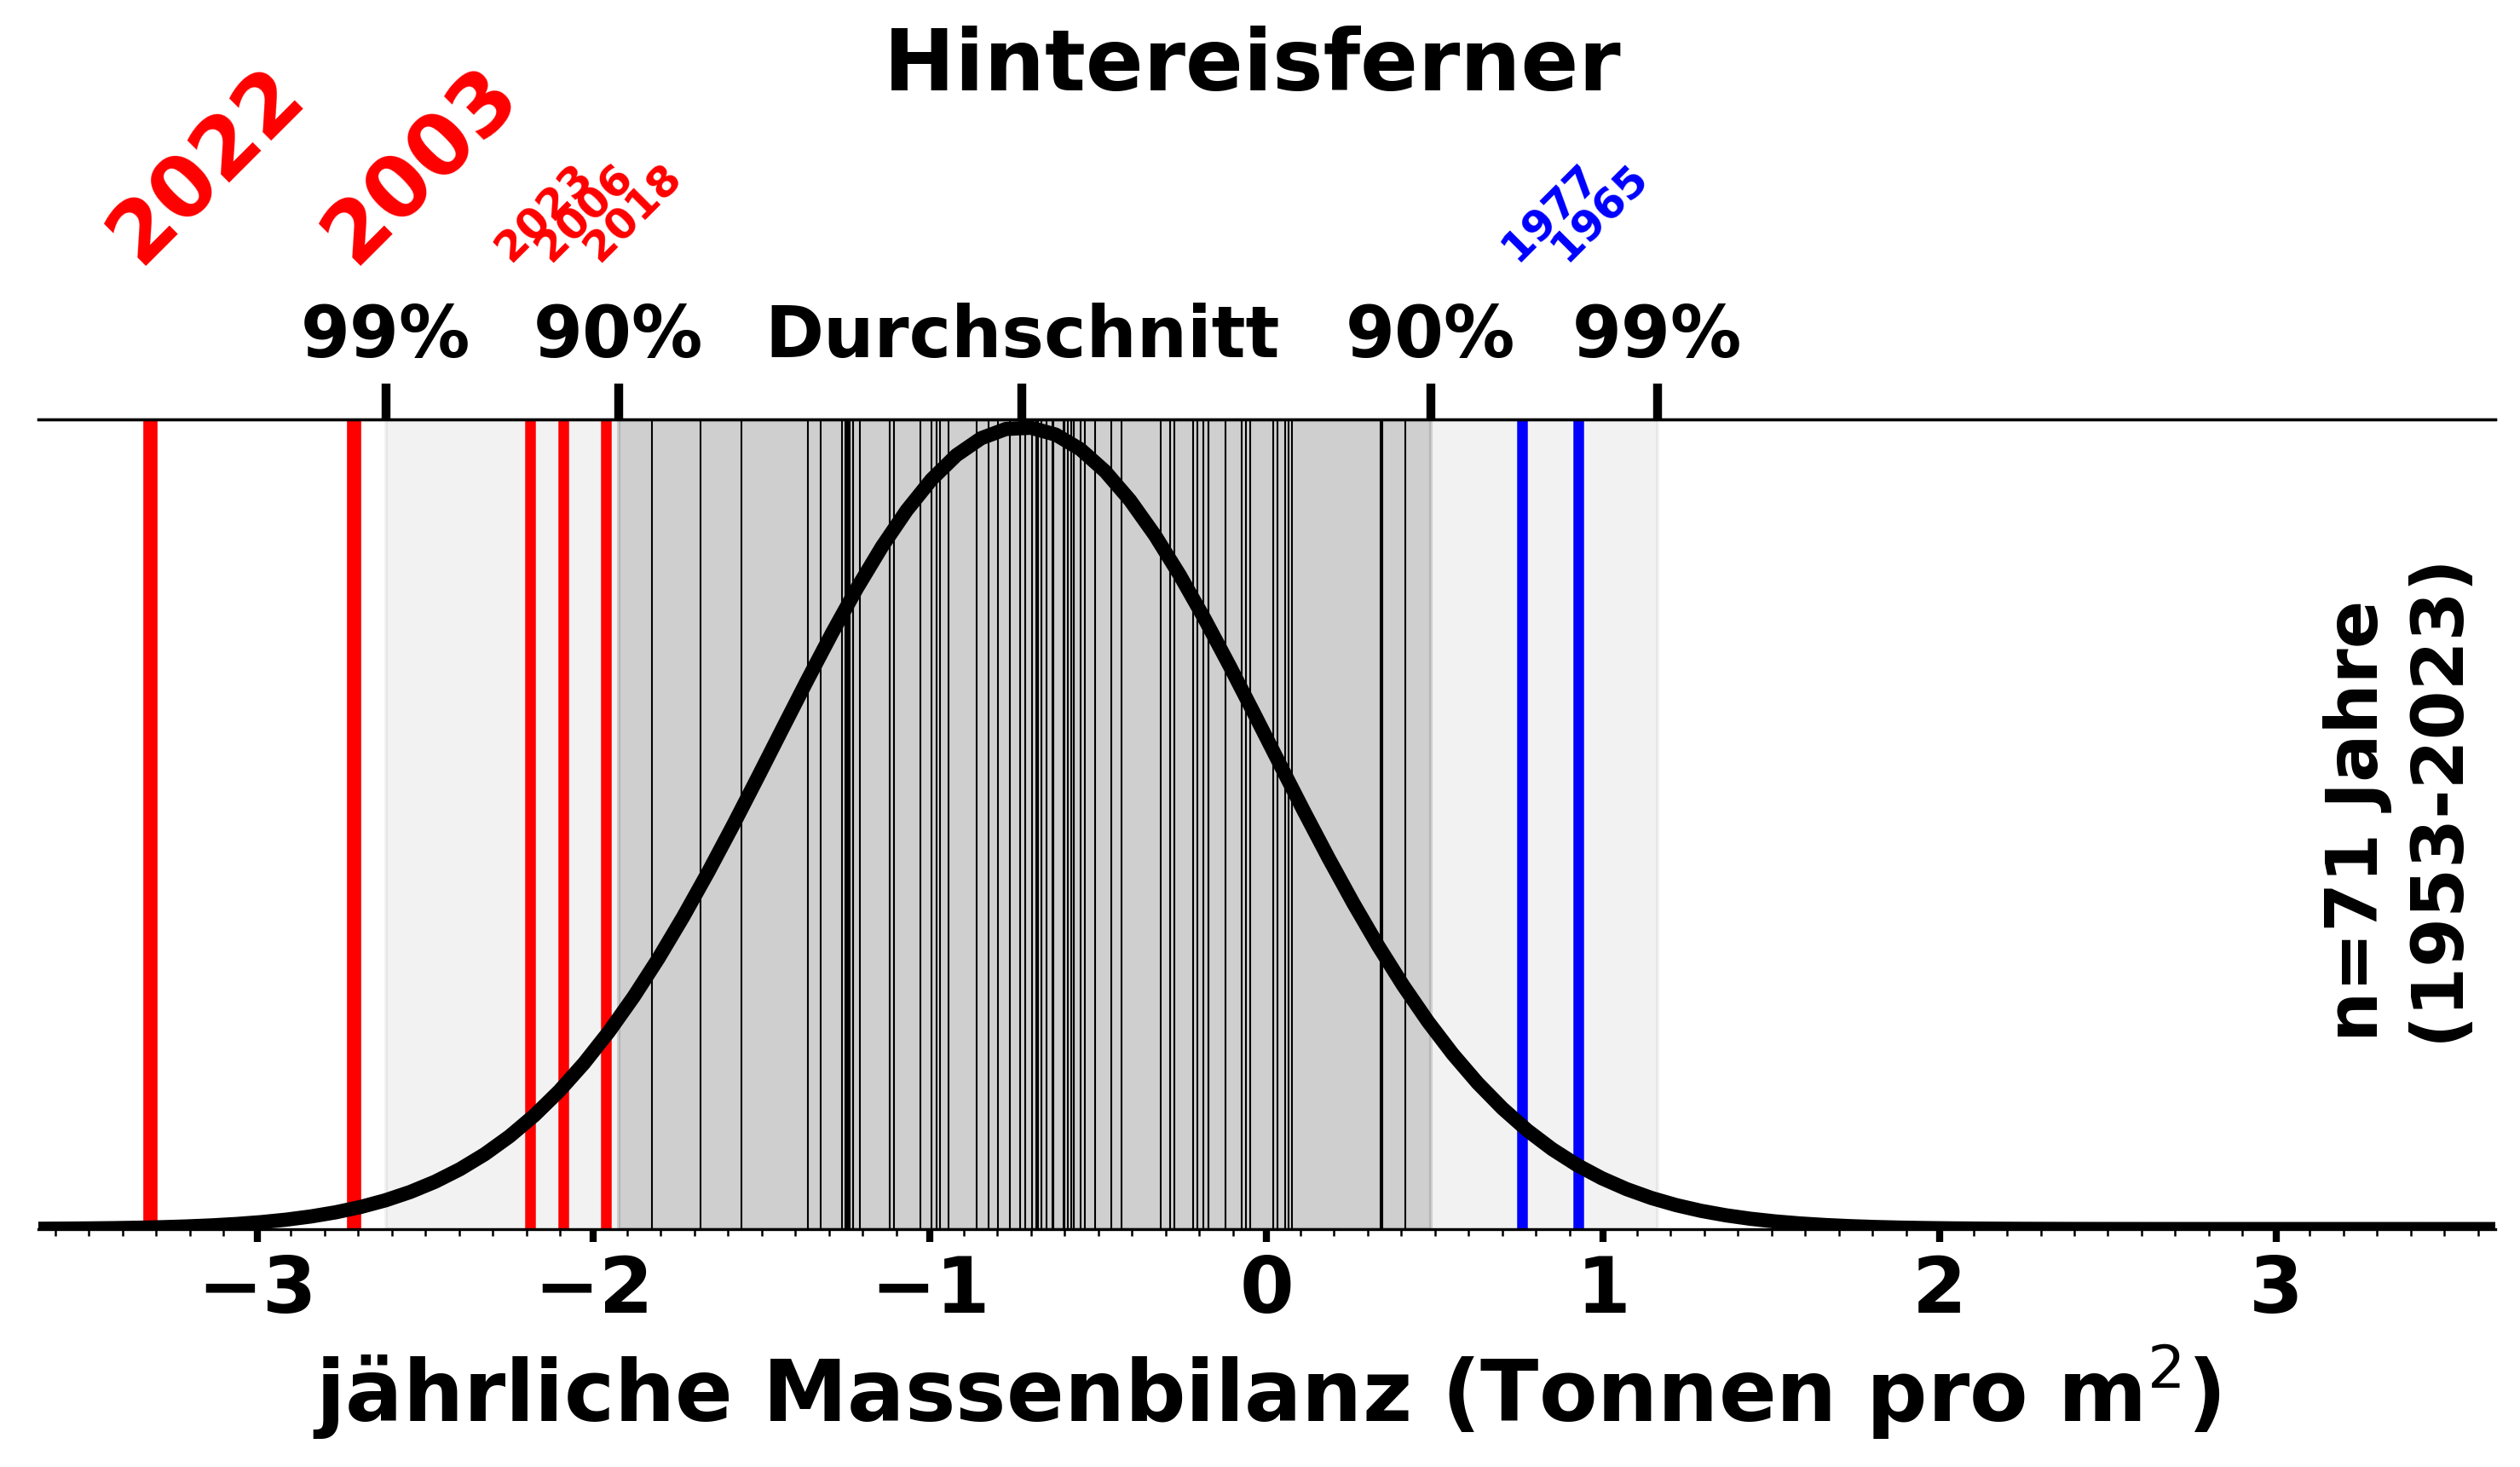

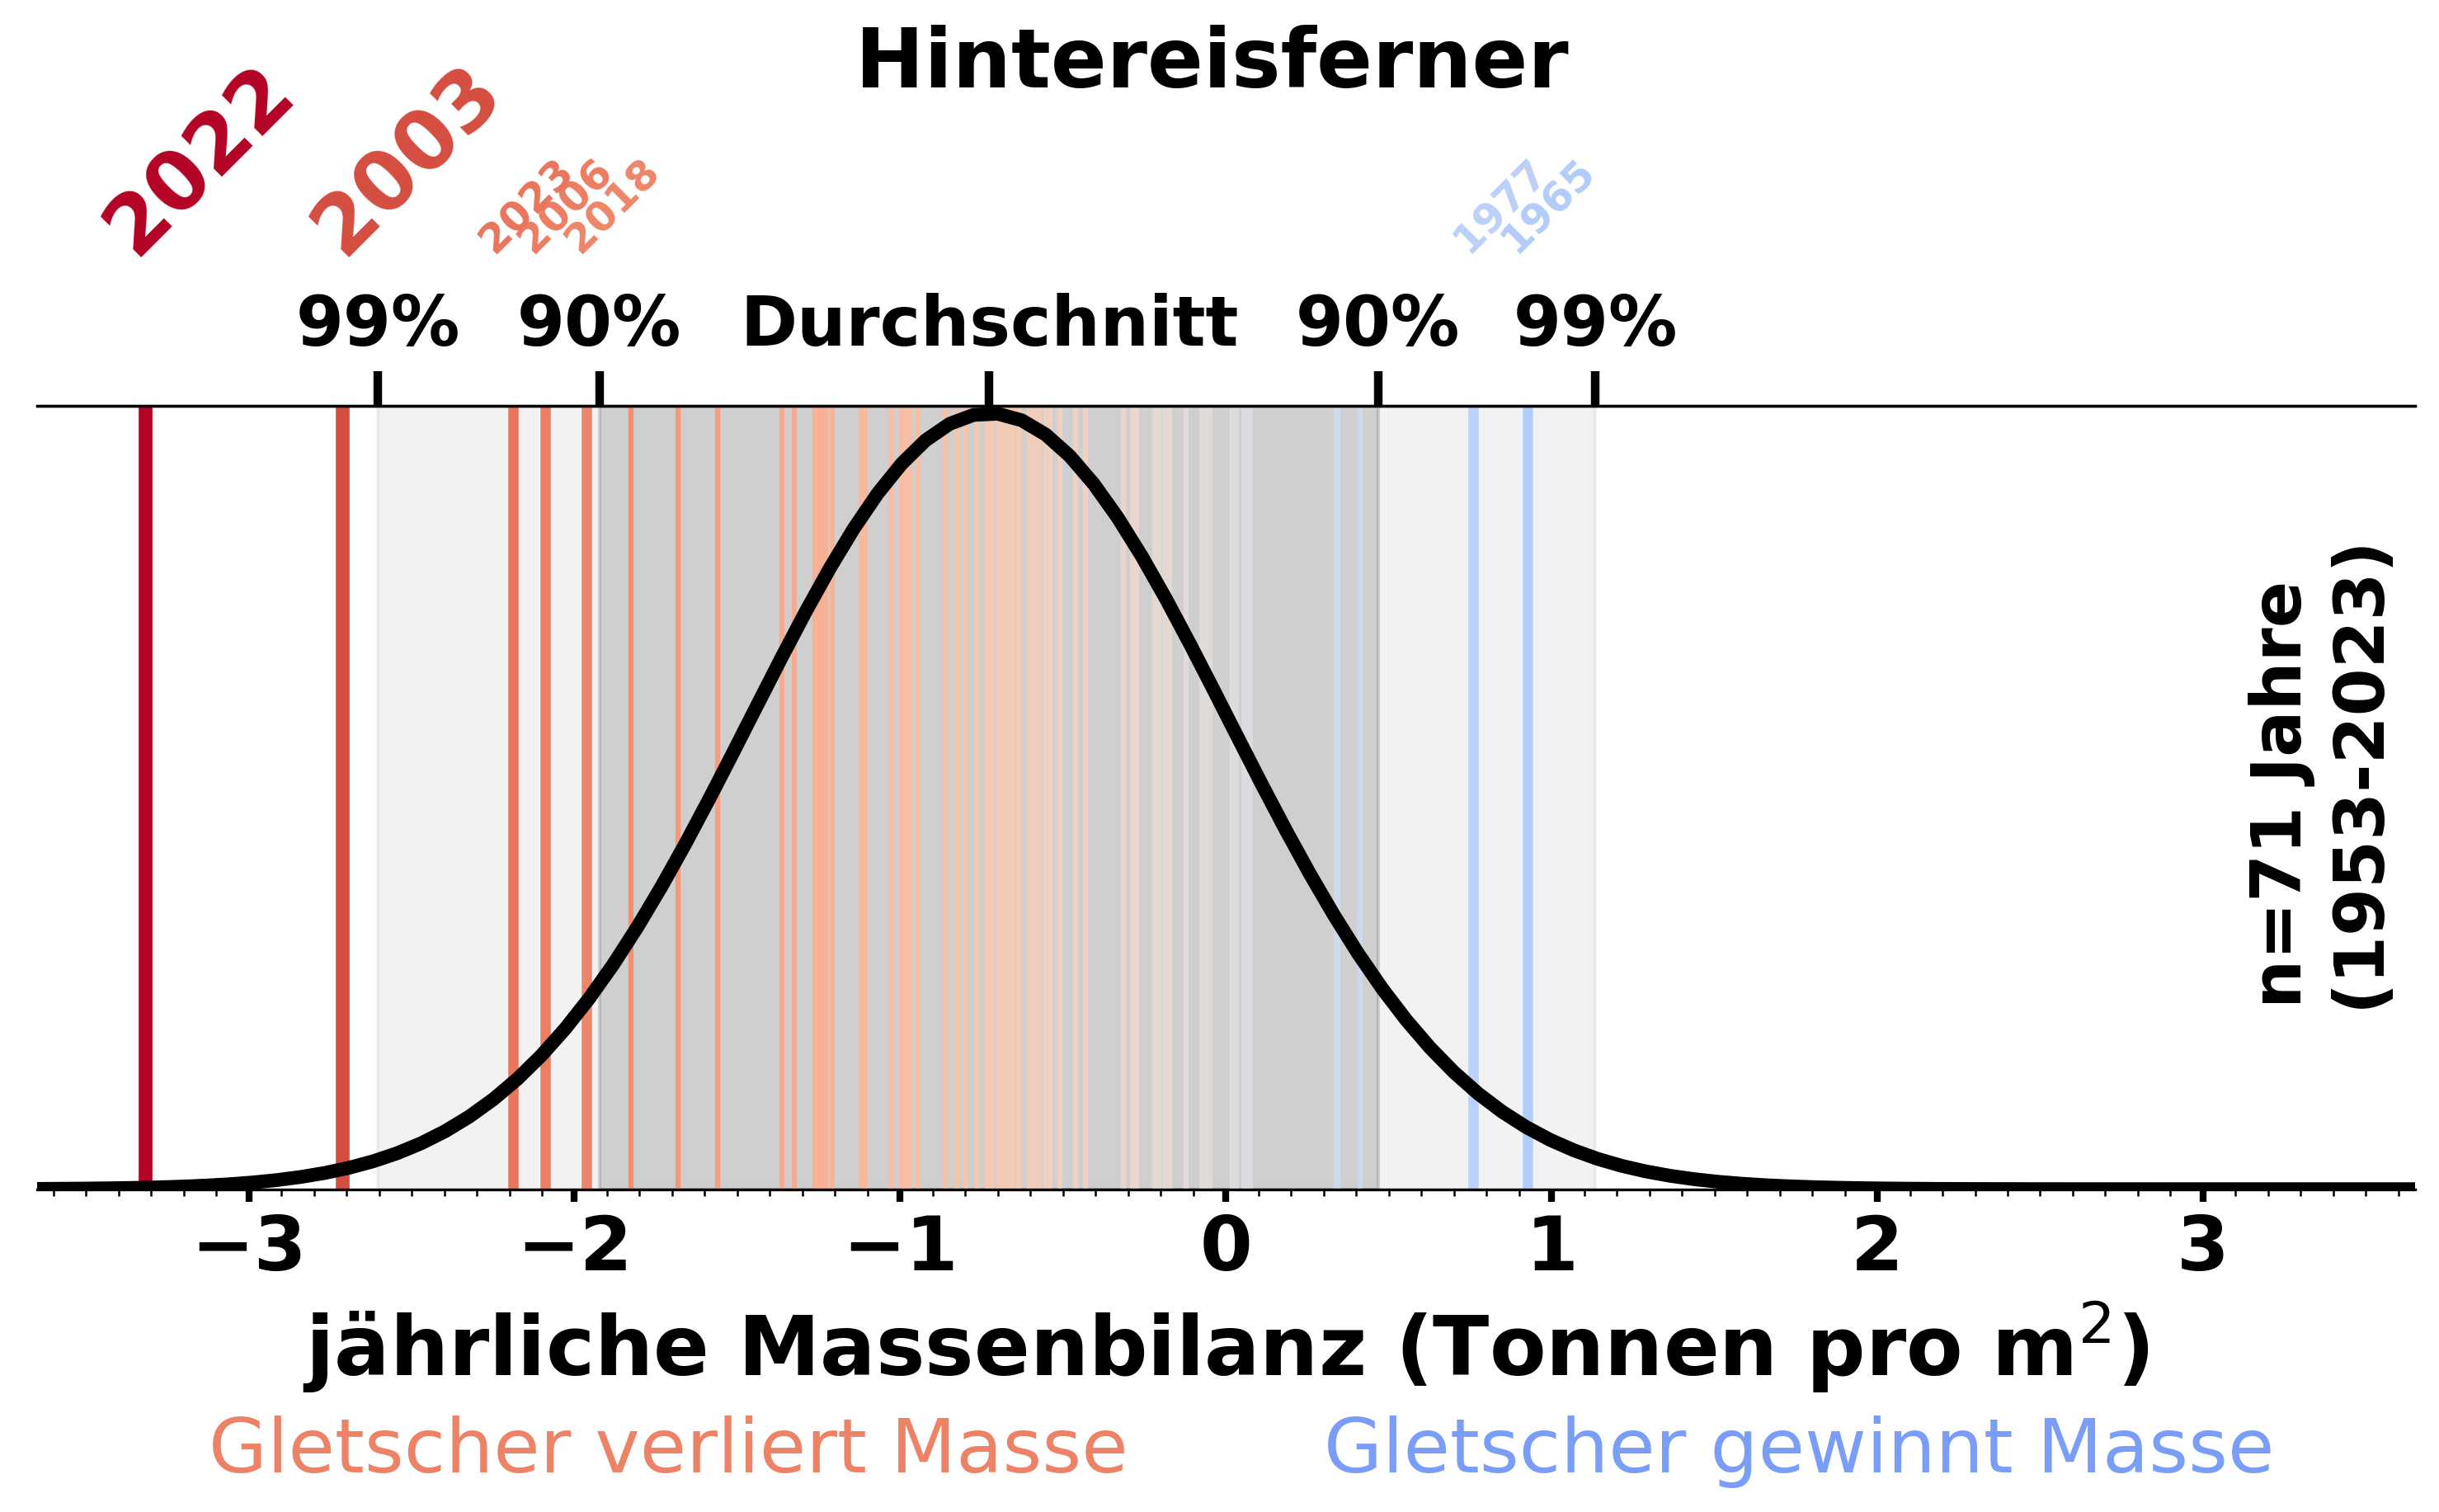

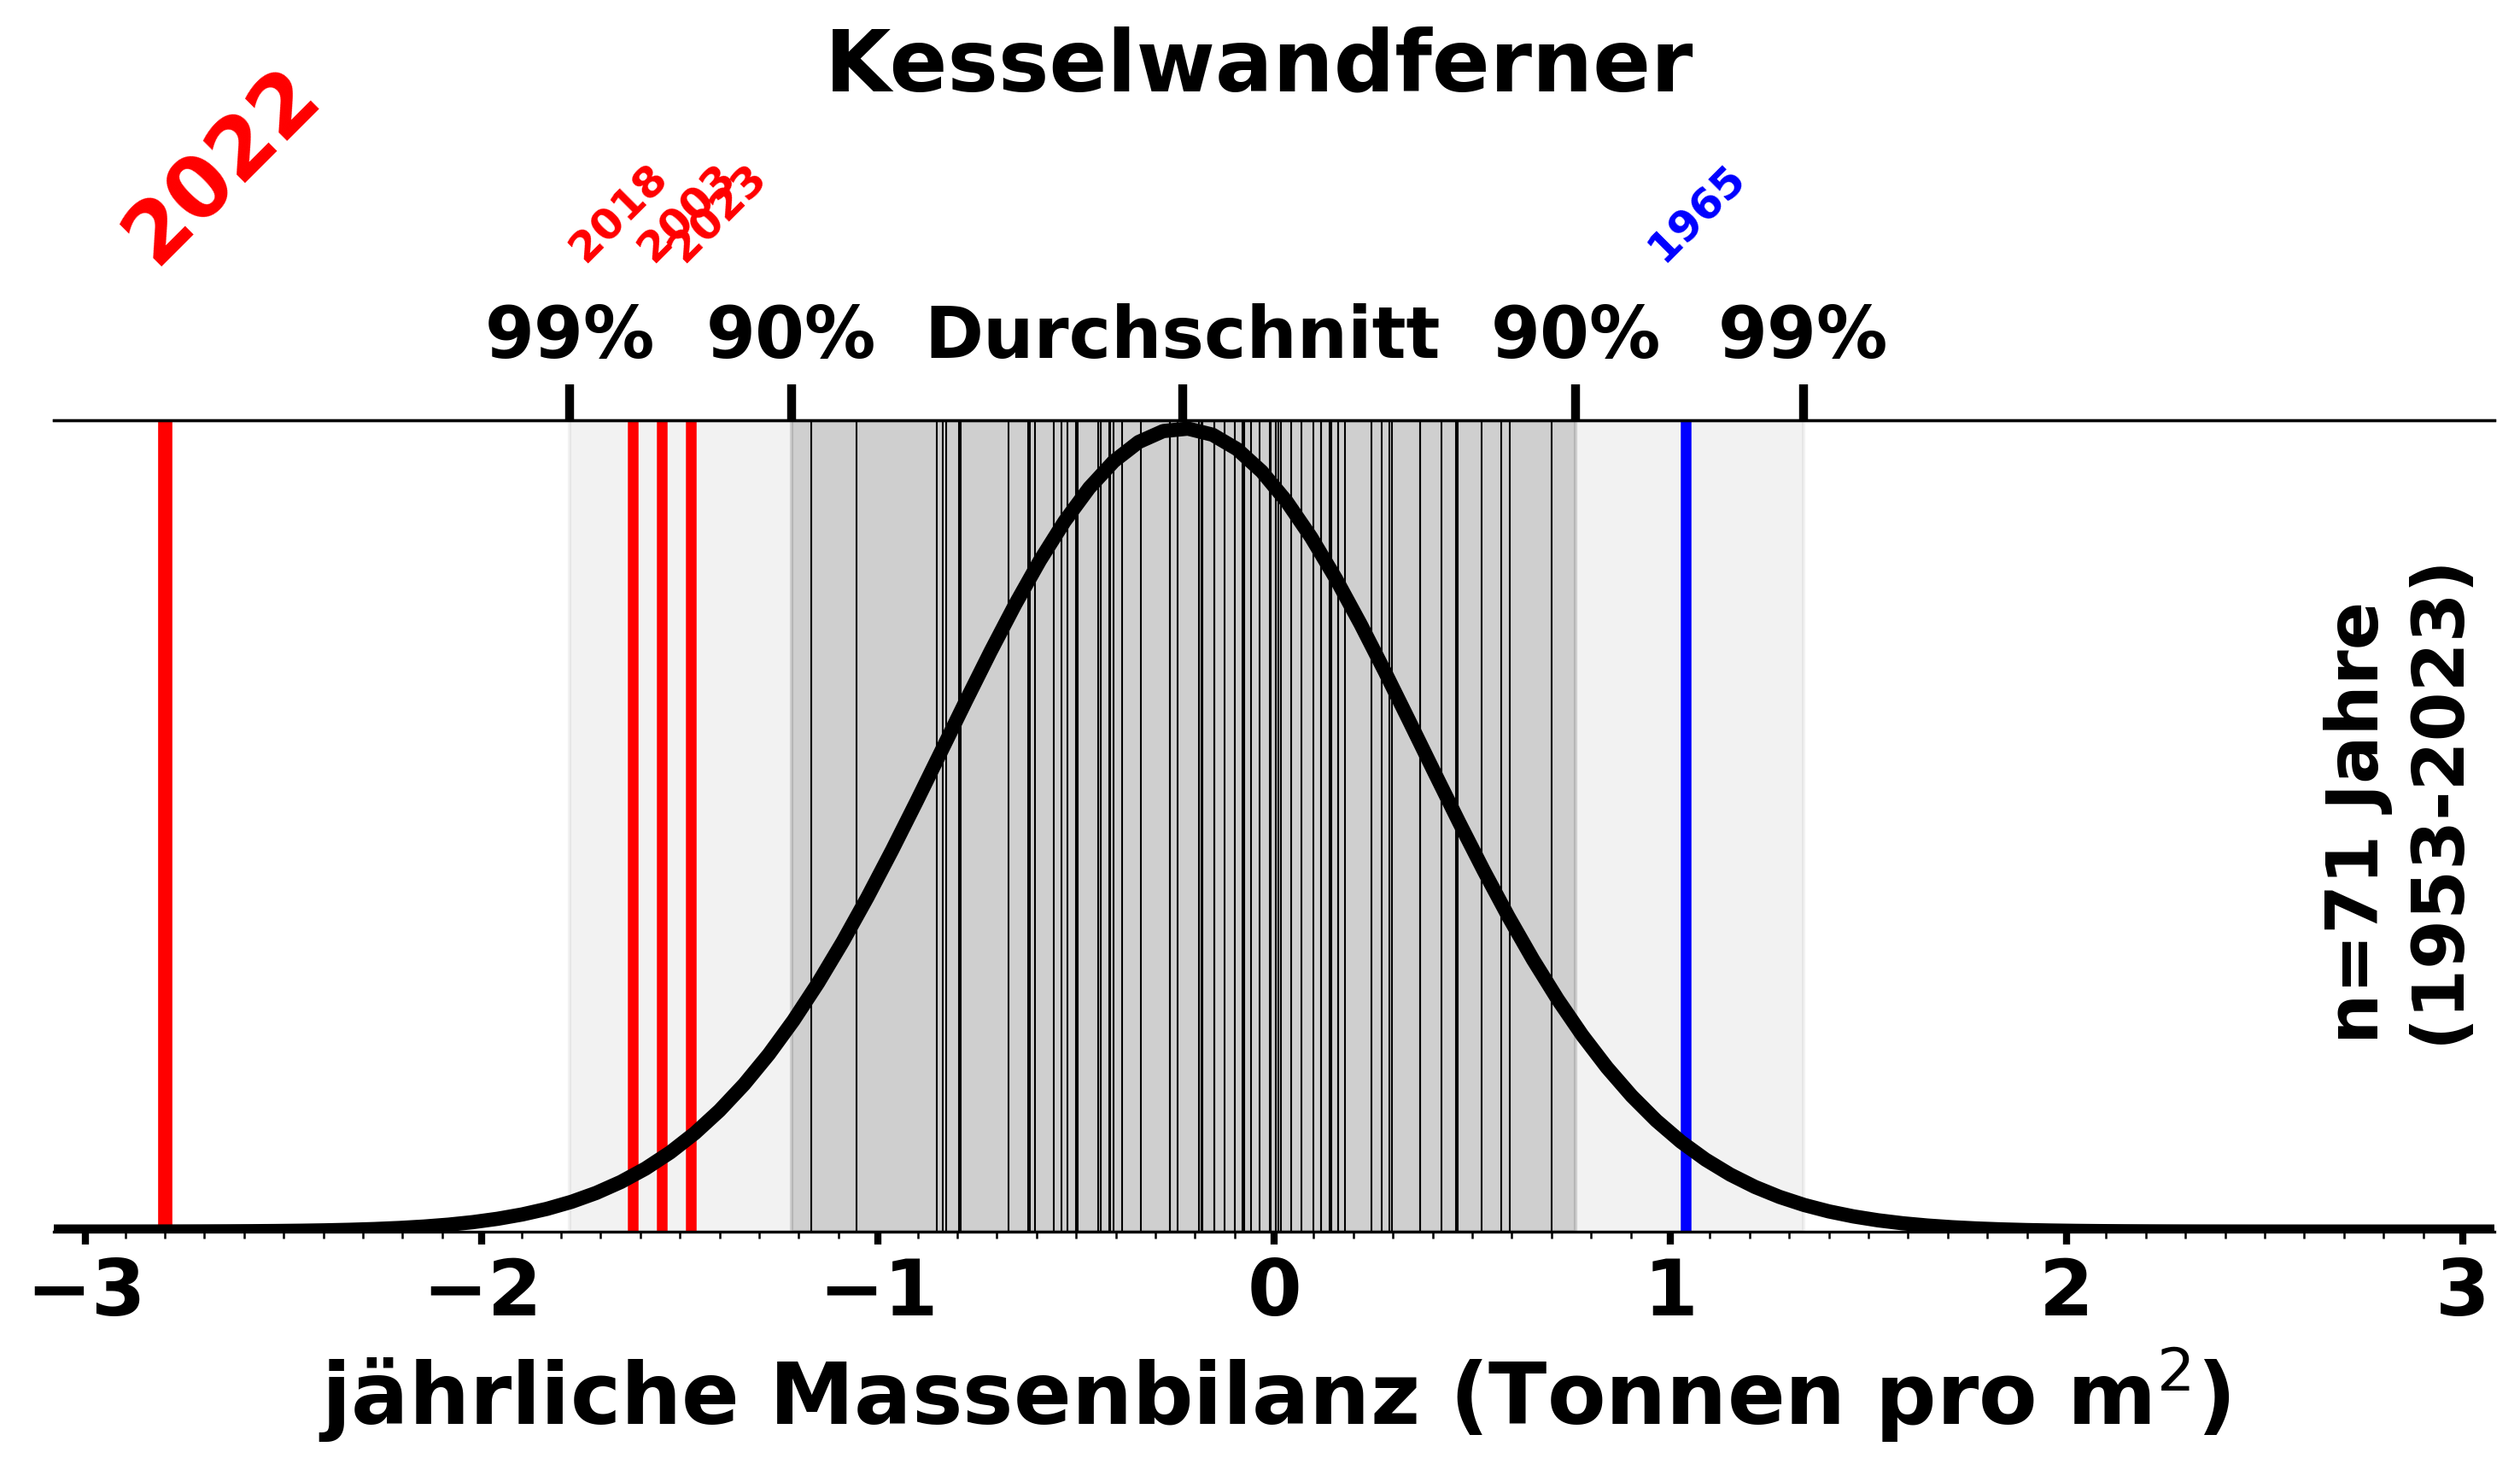

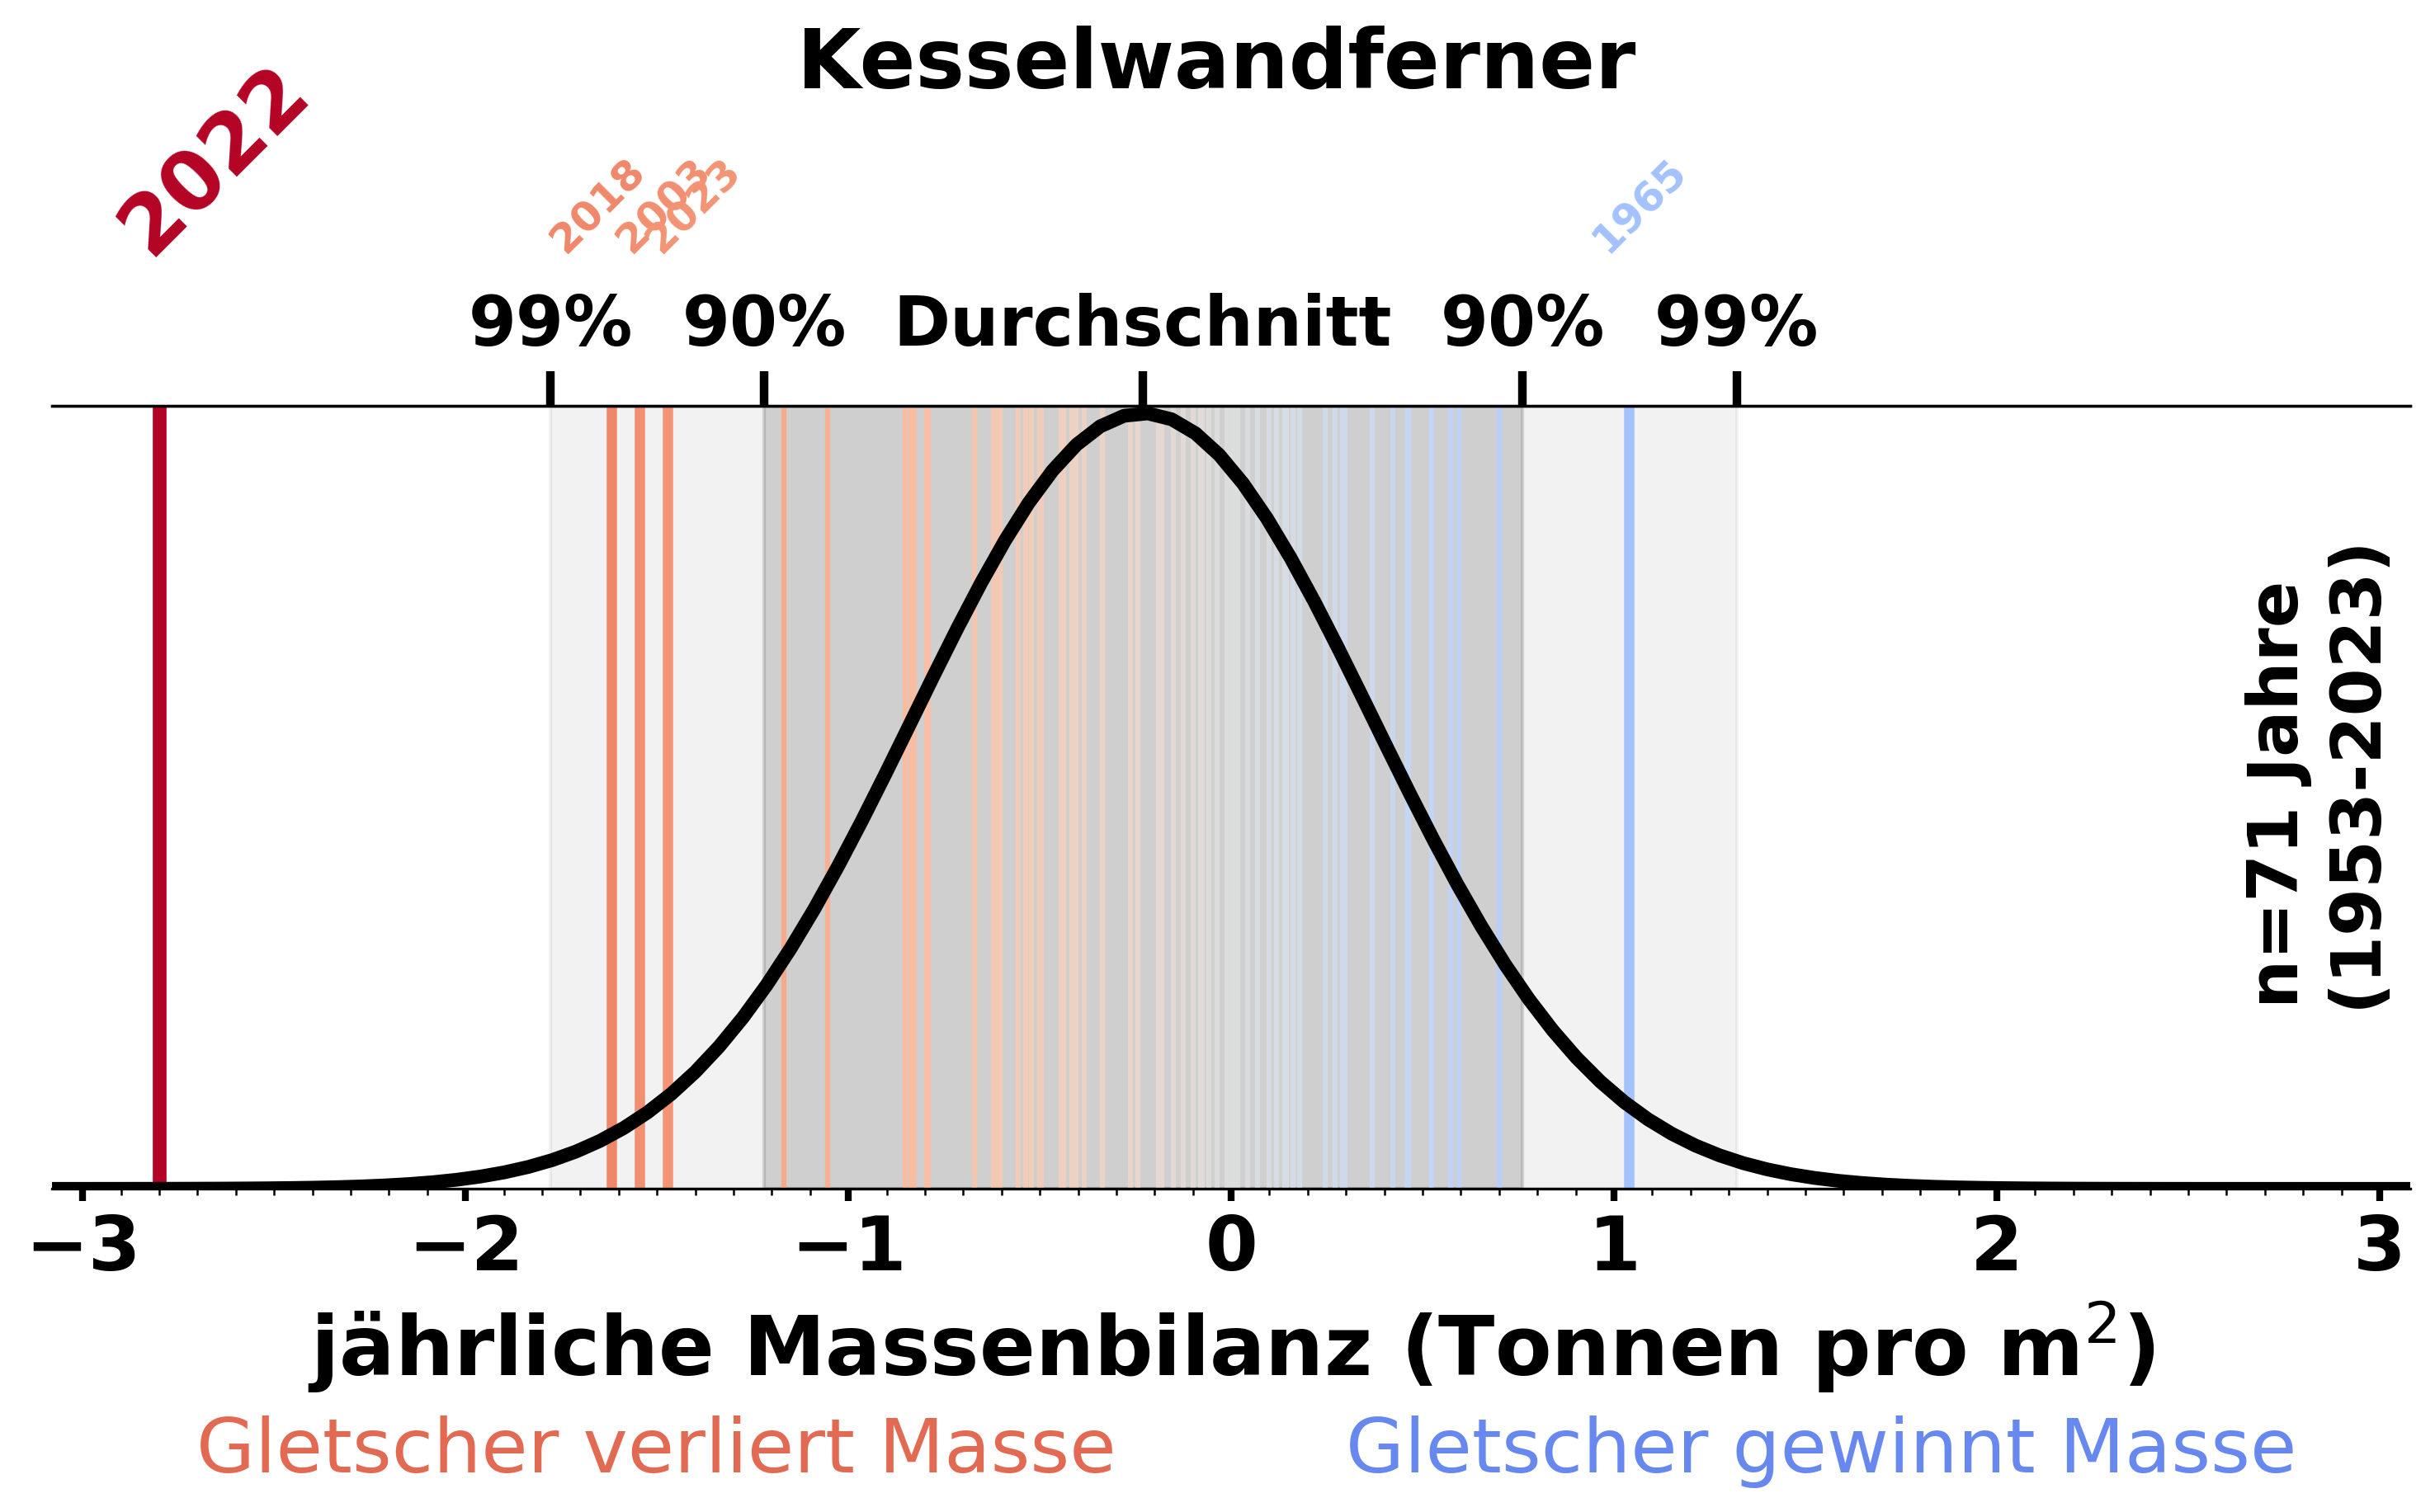

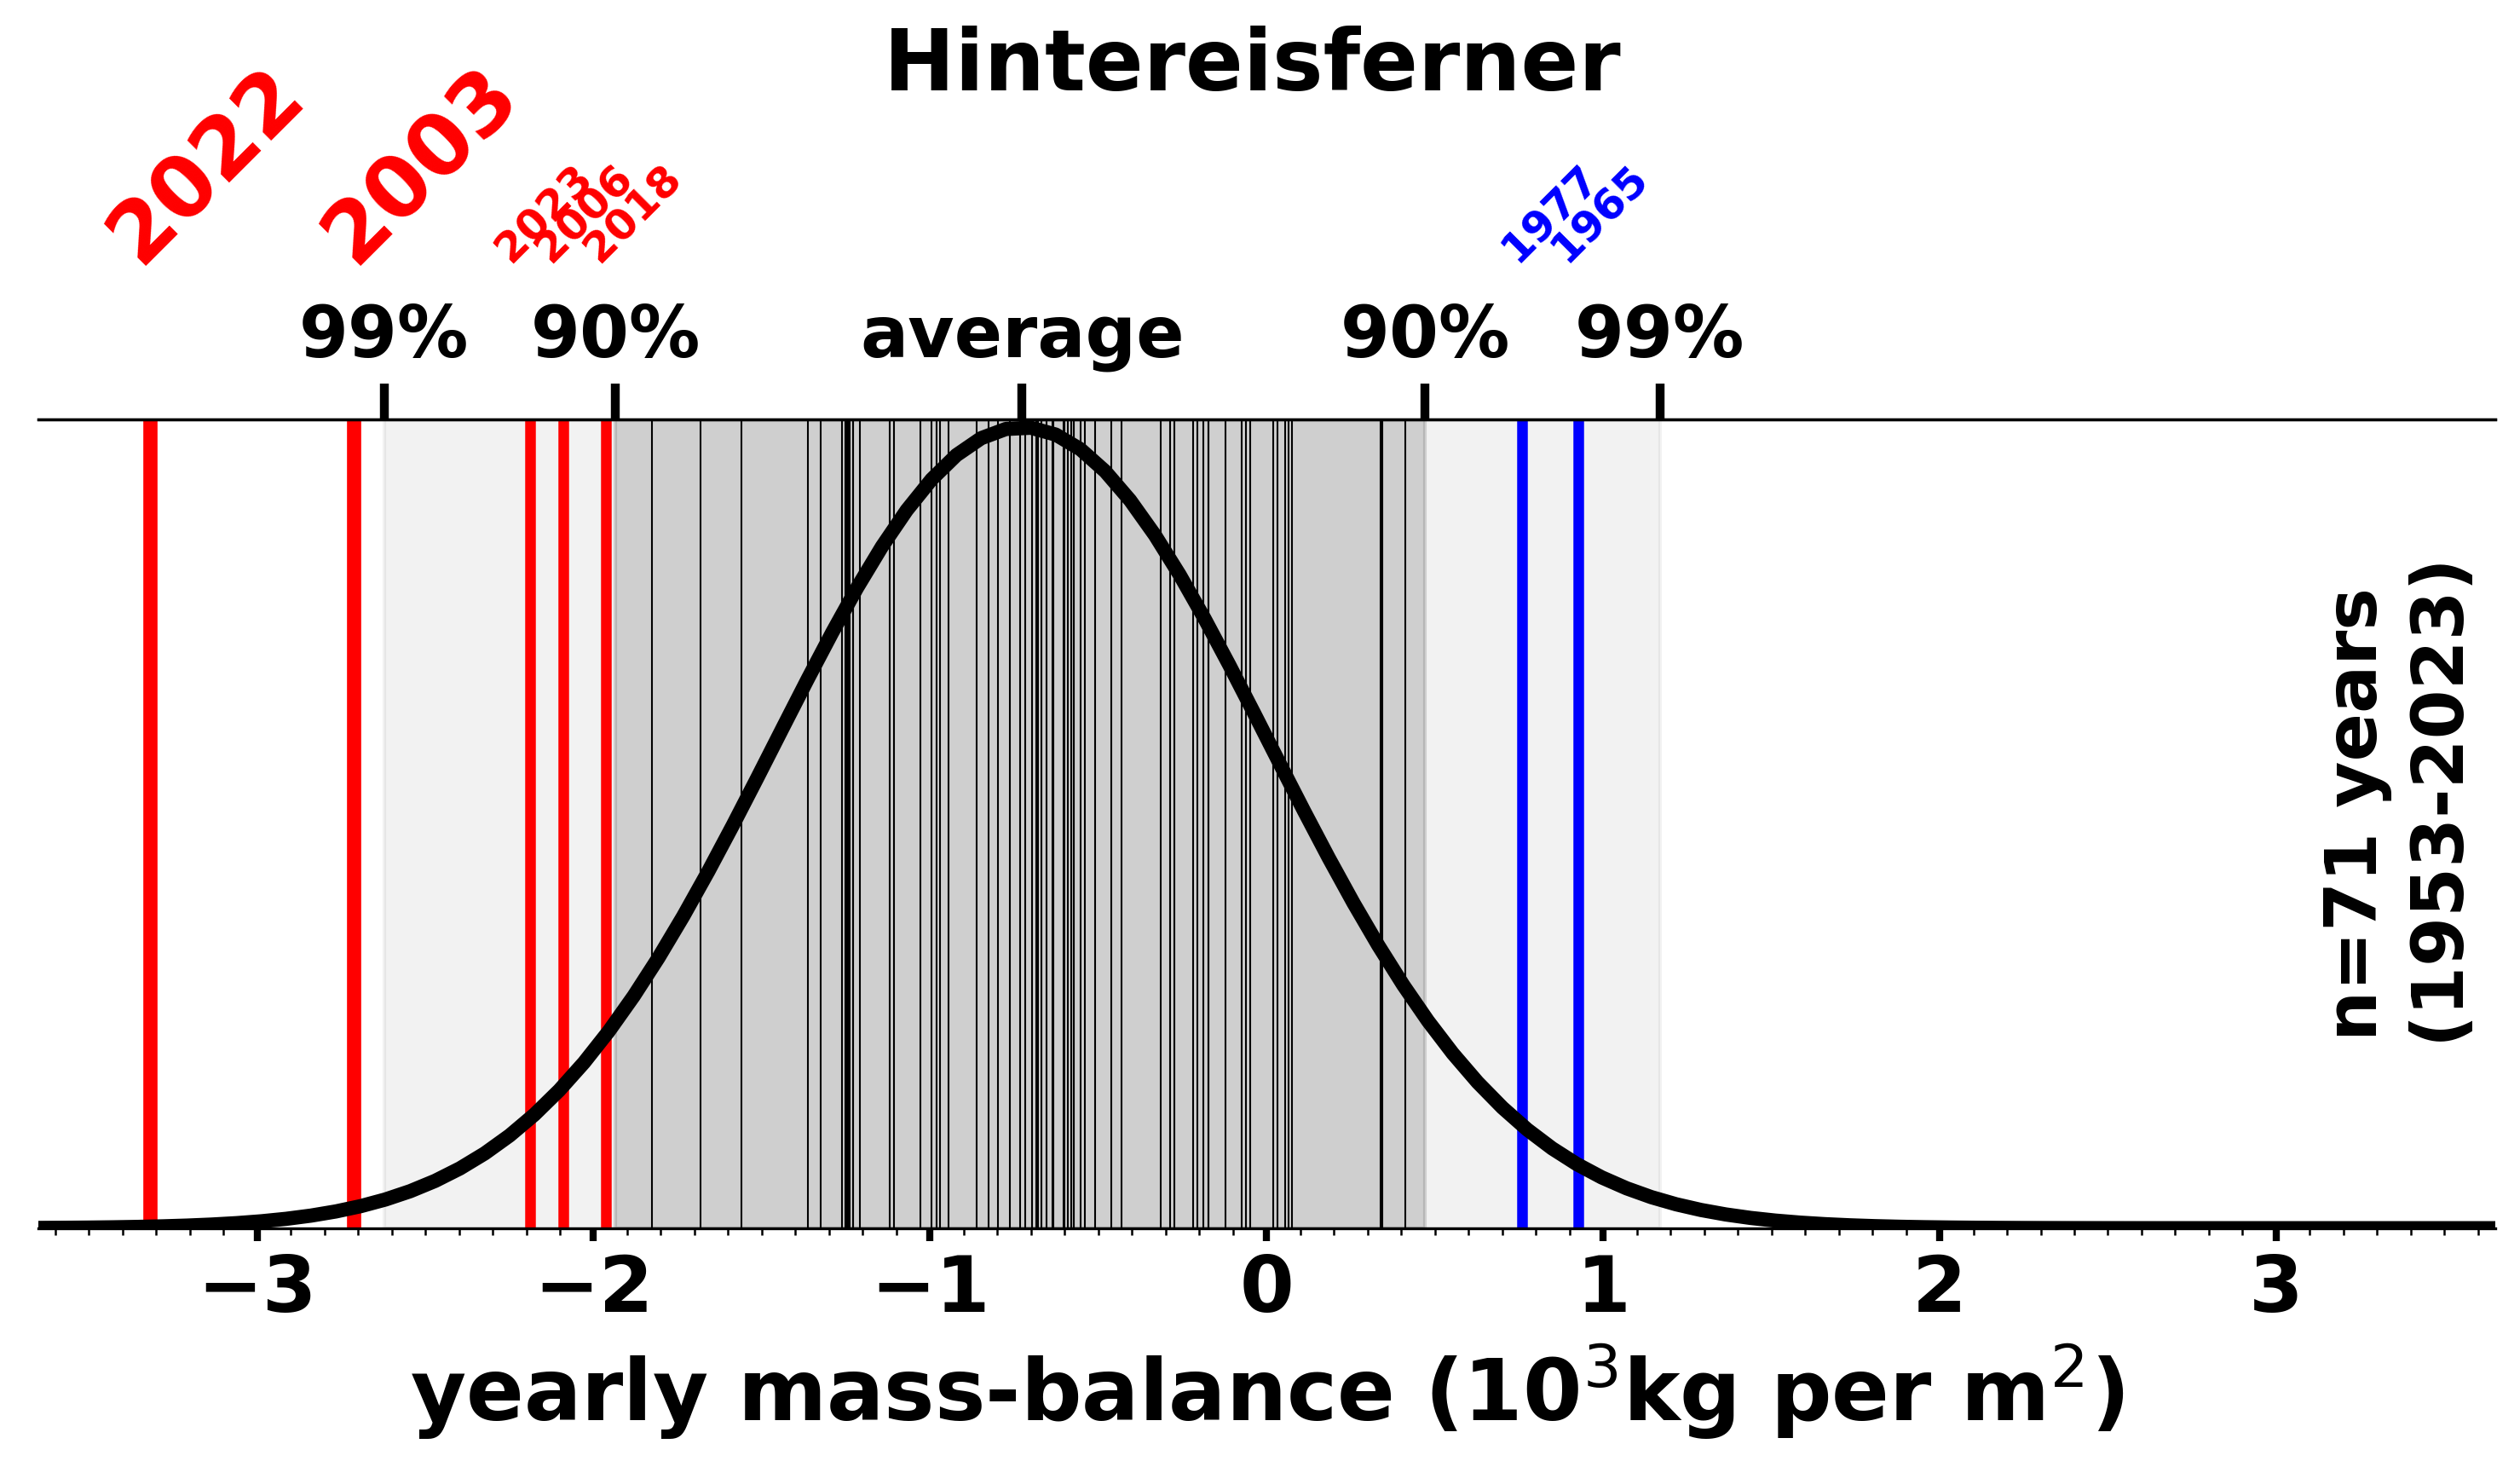

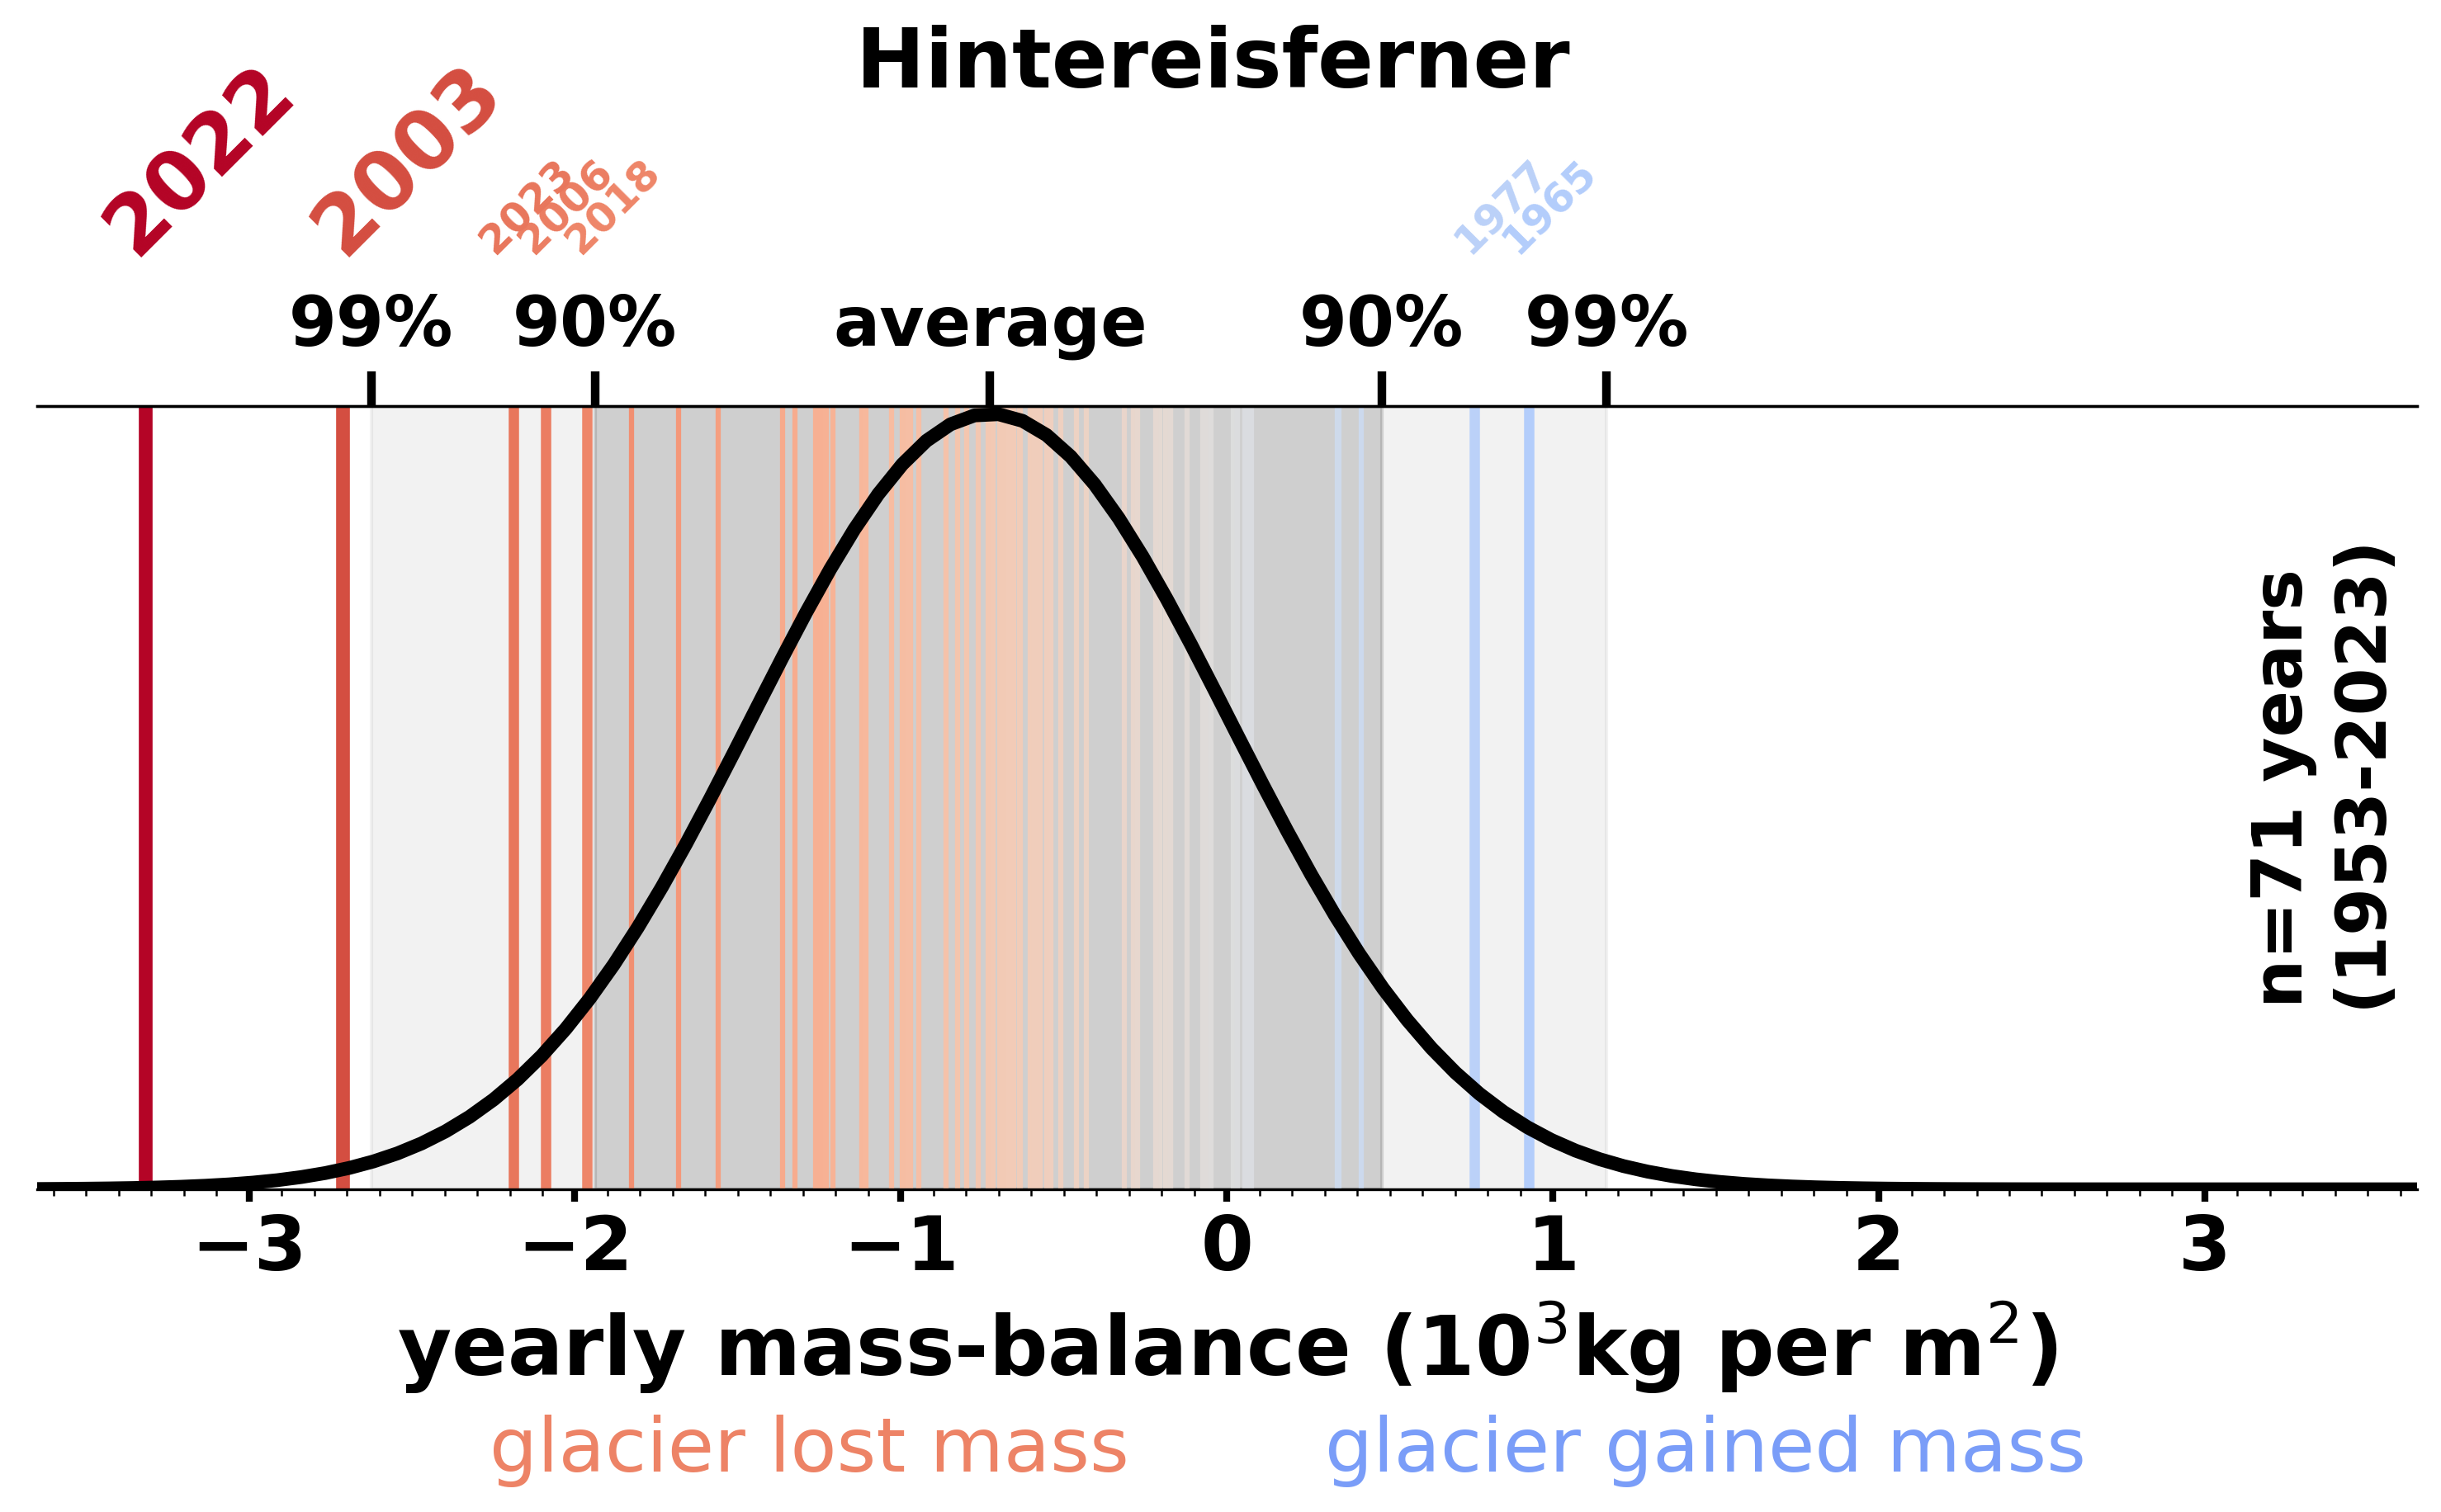

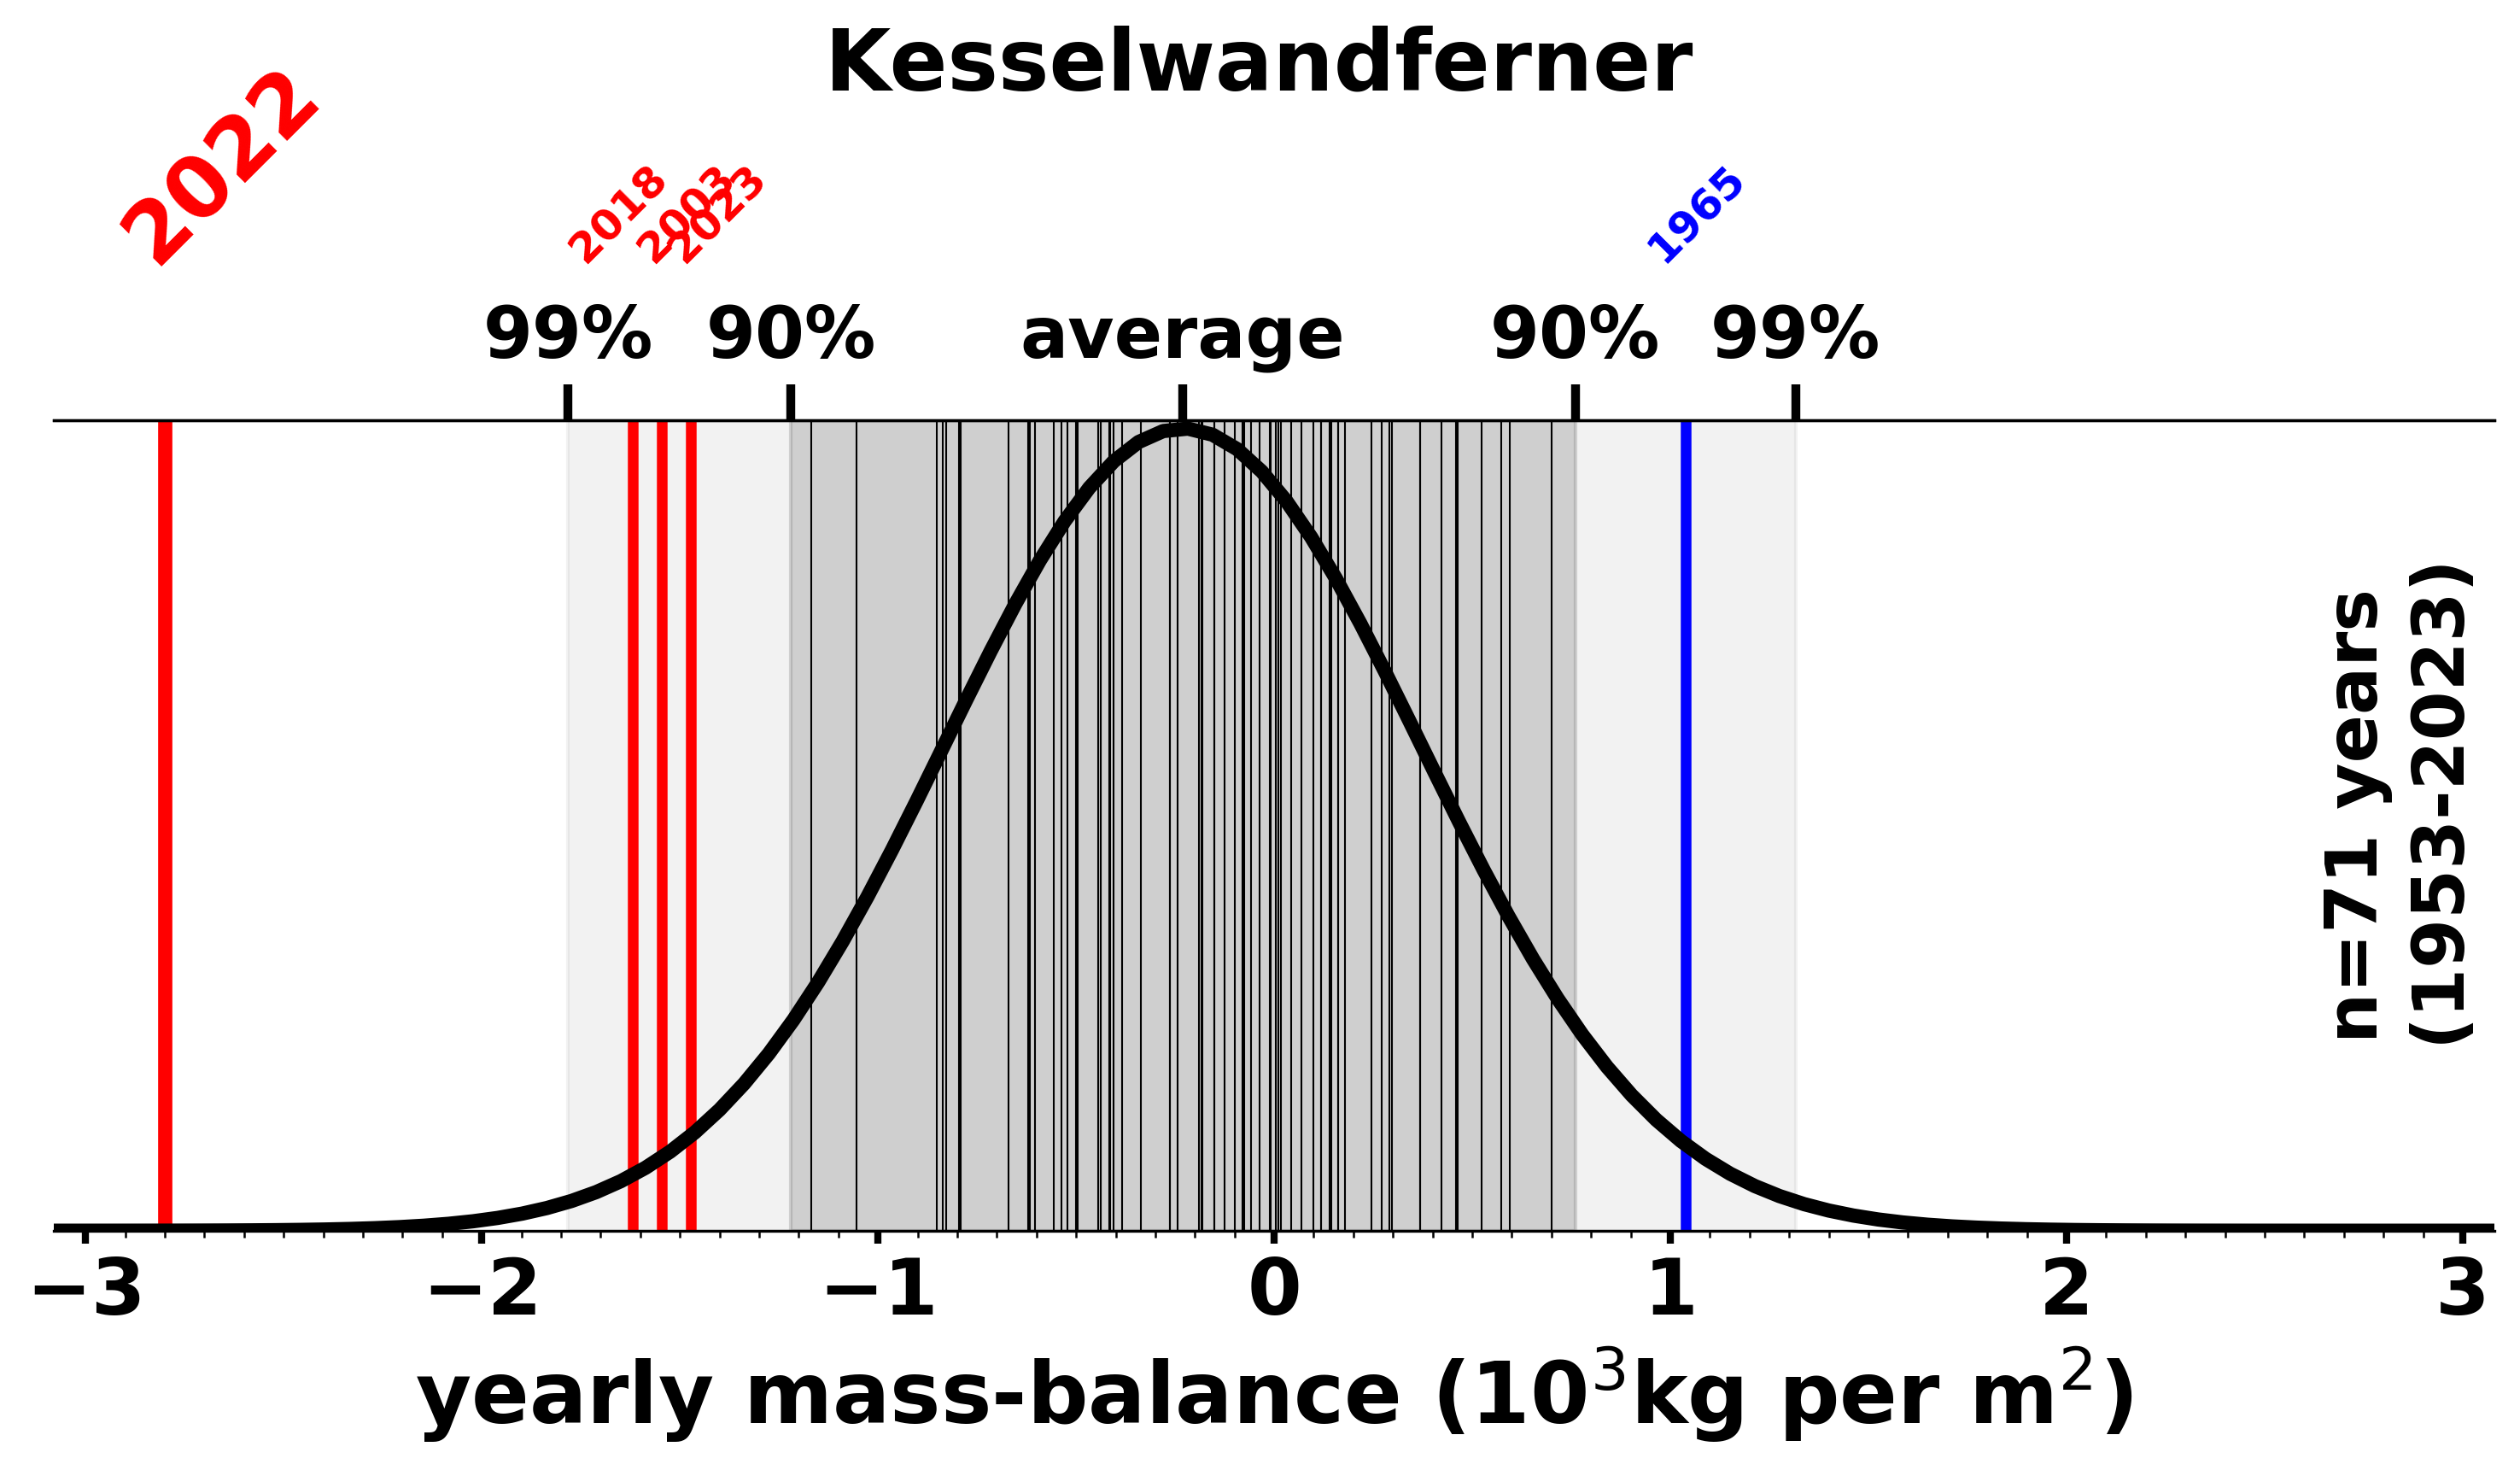

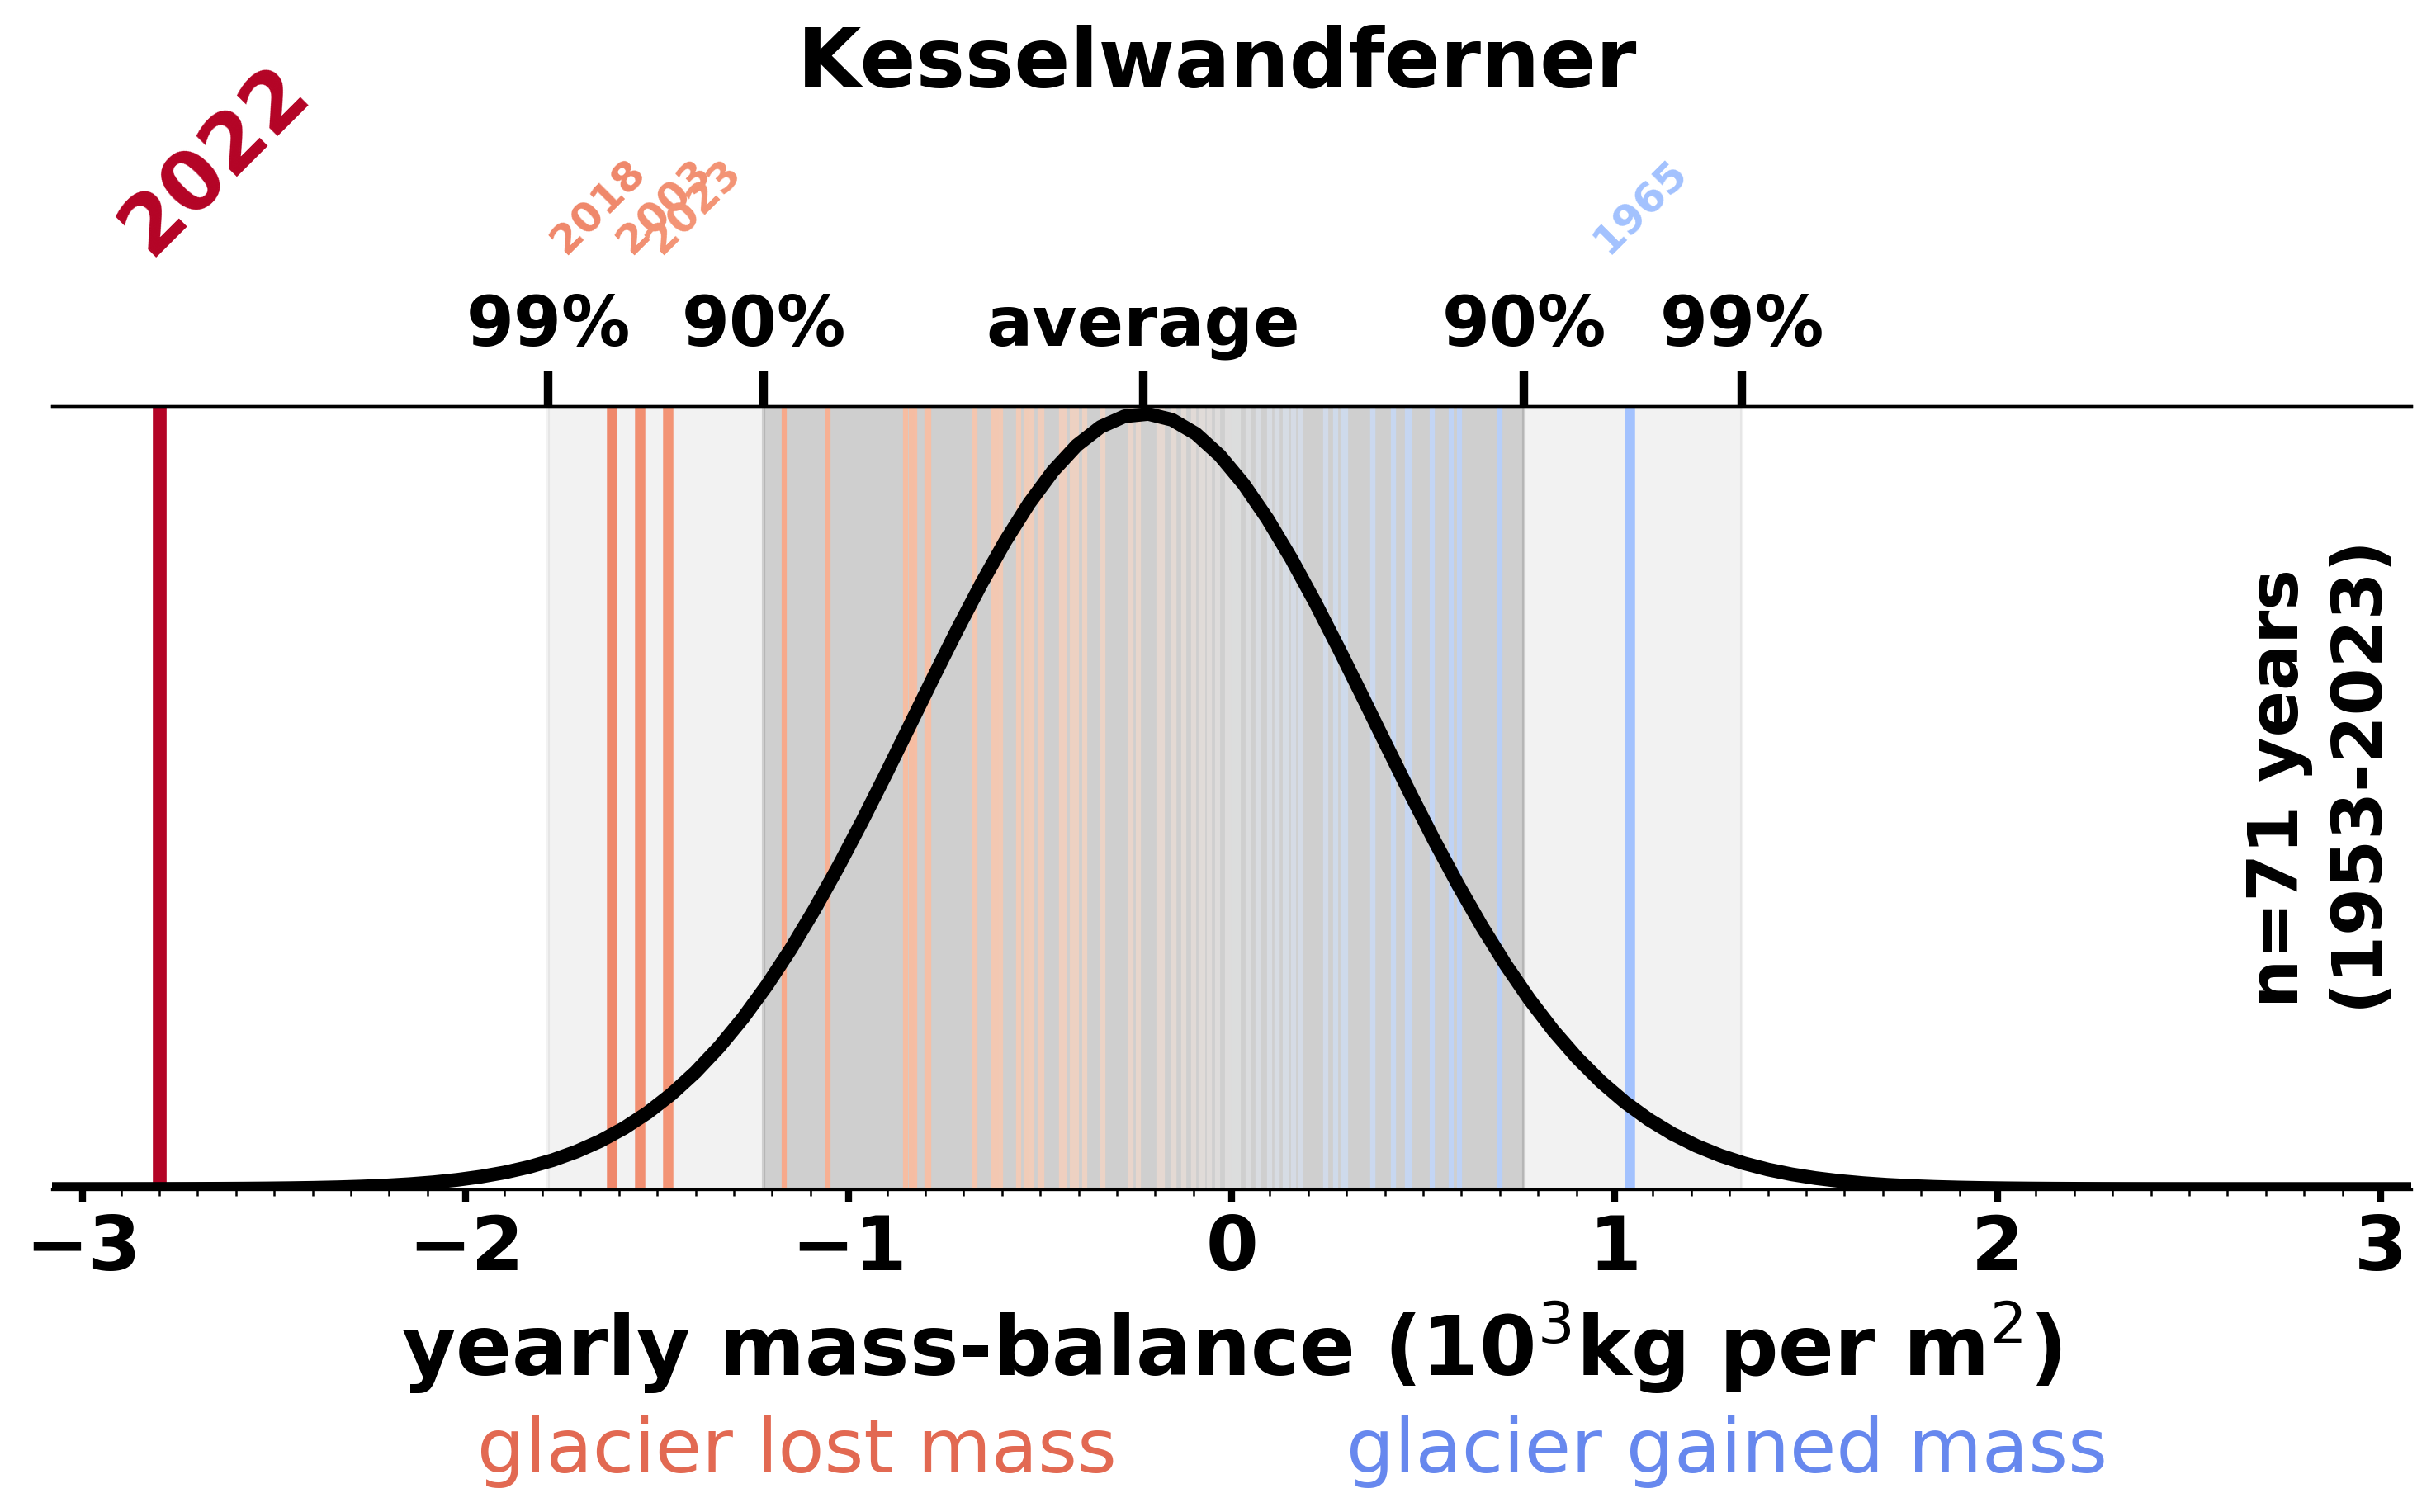

In [28]:
for save in ['save_png', 'save_pdf_svg']: # 'save_png', 
    for language in ['german', 'english']:
        # the arrow - line connections to display the ranges somehow work differently if saved as png or as pdf svg, therefore I need different numbers to get "similar" outcomes
        if save == 'save_png':
            armB = 150
        elif save == 'save_pdf_svg':
            armB = 45
        arrowprops = {"arrowstyle":"-", "color":"gray", "connectionstyle":f"arc,angleA=0,angleB=90,armA=0,armB={armB},rad=30", "lw":2}
        for glacier in ['Hintereisferner', 'Kesselwandferner']:
            # the test "glacier lost mass" and "..gained mass", needs different y-location depending on the glacier scale
            # this is adapted here, could be automated if you want to do it on other glaciers ... 
            if glacier == 'Hintereisferner':
                y_span_text_m = 0.18
            elif glacier == 'Kesselwandferner':
                y_span_text_m = 0.22
            for version in ['simple', 'advanced']:
                if glacier == 'Hintereisferner':
                    spec_mb_values = spec_mb['HEF mass balance (kg/m-2)']/1000  # convert to m w.e.
                elif glacier == 'Kesselwandferner':
                    spec_mb_values = spec_mb['KWF mass balance (kg/m-2)']/1000  # convert to m w.e.

                # get maximum specific mb and use them as limits for the plots and for the colormap scales 
                # we center the mass balance at 0, hence we just get the maximum absolute value 
                xlims_abs = np.max([np.absolute(spec_mb_values.max()),
                        np.absolute(spec_mb_values.min())])*1.1
                if version == 'advanced':
                    # for the blue-red colormap (only necessary for advanced version)
                    # that is centered at MB = 0
                    # normalize item number values to colormap
                    # strongest color for the maximum absolute MB
                    norm_col = matplotlib.colors.Normalize(vmin=-np.max([np.absolute(spec_mb_values.max()), 
                                                                         np.absolute(spec_mb_values.min())]),
                                                           vmax=np.max([np.absolute(spec_mb_values.max()), 
                                                                        np.absolute(spec_mb_values.min())]))

                fig,_ = plt.subplots(1,1,figsize=(10,6))
                fig.set_dpi(300)

                # plot each year as vertical line 
                for j, yr in enumerate(spec_mb.index):
                    if version == 'advanced':
                        color =  cm.coolwarm_r(norm_col(spec_mb_values))[j]
                        lw = 1.5
                    else:
                        color = 'black'
                        lw = 0.5
                    plt.axvline(spec_mb_values.loc[yr], color = color, lw=lw)

                plt.xlim([-xlims_abs, xlims_abs])

                # fit and plot the gaussian distribution (fitted from the observations)
                # get mean and std of the observed specific mb values
                mean, std = norm.fit(spec_mb_values)
                xmin, xmax = -xlims_abs,xlims_abs
                x = np.linspace(xmin, xmax, 100)
                y = norm.pdf(x, mean, std)
                plt.plot(x, y, lw=4, color='black', zorder=99)

                # check if a year is "extreme" (outside the mean +/- 2std or mean +/- 3 std)
                # if this is true, draw the vertical line bigger and in color (depending on if it is a positive or negative extreme)
                # horizontal displacement of year text
                # create random values and then compute the quantiles to get the 90% and 99%-range
                gauss_dis_random_vals=np.random.normal(loc=mean, scale=std, size=100000)
                q005,q05,q95,q995 = np.quantile(gauss_dis_random_vals, q=[0.005, 0.05,0.95,0.995])
                for j,yr in enumerate(spec_mb.index):
                    if glacier == 'Kesselwandferner':
                        if yr==2018:
                            x_ch = 1.11
                        else:
                            x_ch = 1.05
                    else:
                        x_ch = 1.05
                    if spec_mb_values.loc[yr] < q005: #mean-3*std:
                        if version == 'advanced':
                            color = cm.coolwarm_r(norm_col(spec_mb_values))[j]
                        else:
                            color = 'red'
                        ## very negative MB extremes in red
                        plt.axvline(spec_mb_values.loc[yr], color = color, lw=4)
                        plt.text(spec_mb_values.loc[yr]*x_ch,y.max()+y.max()/4.8 ,f'{yr}', 
                                 rotation=45, fontsize=24, fontweight='bold', color = color, zorder=2)
                    elif spec_mb_values.loc[yr] < q05:
                        if version == 'advanced':
                            color = cm.coolwarm_r(norm_col(spec_mb_values))[j]
                        else:
                            color = 'red'
                        ## negative MB extremes in red
                        plt.axvline(spec_mb_values.loc[yr], color = color, lw=3)
                        if yr == 2023 and glacier == 'Hintereisferner':
                            shift = -0.015
                        elif yr == 2018 and glacier == 'Hintereisferner':
                            shift = +0.01
                        else:
                            shift = 0
                        plt.text(spec_mb_values.loc[yr]*x_ch  + shift,y.max()+y.max()/4.8,f'{yr}', #%': year {spec_mb_values.index[0]}-{spec_mb_values.index[-1]}',
                                 rotation=45, 
                                 fontsize=12, fontweight='bold', color = color, zorder=2)
                    elif spec_mb_values.loc[yr] > q95:
                        if version == 'advanced':
                            color = cm.coolwarm_r(norm_col(spec_mb_values))[j]
                        else:
                            color = 'blue'
                        ## positive MB extremes 
                        plt.axvline(spec_mb_values.loc[yr], color = color, lw=3)
                        plt.text(spec_mb_values.loc[yr]*0.89,
                                 y.max()+y.max()/4.8 ,f'{yr}', 
                                 rotation=45, 
                                 fontsize=12, fontweight='bold', color = color, zorder=2)
                    elif spec_mb_values.loc[yr] > q995: #mean+3*std:
                        # does not occur for HEF and KWF, but maybe for other glaciers
                        if version == 'advanced':
                            color = cm.coolwarm_r(norm_col(spec_mb_values))[j]
                        else:
                            color = 'blue'
                        ## positive MB extremes 
                        plt.axvline(spec_mb_values.loc[yr], color = color, lw=4)
                        plt.text(spec_mb_values.loc[yr]*0.89,
                                 y.max()+y.max()/4.8 ,f'{yr}', 
                                 rotation=45, 
                                 fontsize=24, fontweight='bold', color = color, zorder=2)
                if language == 'german':
                    plt.xlabel(r'jährliche Massenbilanz (Tonnen pro m$^2$)', fontsize=24, fontweight='bold')
                else:
                    plt.xlabel(r'yearly mass-balance (10$^3$kg per m$^2$)', fontsize=24, fontweight='bold')
                plt.title(f'{glacier} \n \n', fontsize=24, fontweight='bold')
                ax = plt.gca()
                ax.set_xticks(np.arange(-int(xlims_abs)-1, int(xlims_abs)+1.01,0.1), minor=True)
                plt.xticks(ticks=np.arange(-int(xlims_abs), int(xlims_abs)+0.01,1), fontsize=22, fontweight='bold')#, width=2)
                ax.tick_params(axis='x', which='major', labelsize=22, width=2) #,fontweight='bold') #, width=2.5, length=10)

                plt.xlim([-xlims_abs, xlims_abs])
                if language == 'german':
                    plt.text(0.93, 0.25,f'n={len(spec_mb_values)} Jahre\n({spec_mb.index[0]}-{spec_mb.index[-1]})', 
                             rotation=90, transform=plt.gca().transAxes, fontsize=20, fontweight='bold')
                else:
                    plt.text(0.93, 0.25,f'n={len(spec_mb_values)} years\n({spec_mb.index[0]}-{spec_mb.index[-1]})', 
                             rotation=90, transform=plt.gca().transAxes, fontsize=20, fontweight='bold')

                # create secondary axis and plot the quantiles 
                ax2 = ax.secondary_xaxis(location='top')

                ax2.set_xticks([q005,q05,mean,q95,q995])
                if language == 'german':
                    ax2.set_xticklabels(labels= ['99%','90%',r'Durchschnitt','90%','99%'] ,
                                        fontweight='bold', fontsize=18)
                else:
                    ax2.set_xticklabels(labels= ['99%','90%',r'average','90%','99%'] ,
                                        fontweight='bold', fontsize=18)
                ax2.set_zorder(2)
                plot_range = False
                if version=='advanced' and plot_range:
                    # draw the range line to make clearer that this represents the 99%-range & 90% range ...
                    plt.annotate('Bereich', xy=(q05, y.max()*1.01),
                                xytext=(mean-0.3, y.max()*1.18), fontsize=20,color='grey',
                                xycoords='data',
                                  verticalalignment='bottom',
                                 arrowprops=arrowprops,
                                zorder=1) 
                    plt.annotate('Bereich', xy=(q95, y.max()*1.01), alpha=0,
                                xytext=(mean-0.27, y.max()*1.18), fontsize=20, 
                                xycoords='data',
                                                           verticalalignment='bottom',
                                 arrowprops=arrowprops,
                                zorder=1) 

                    plt.annotate('Bereich', xy=(q005, y.max()*1.01), alpha=0,
                                xytext=(mean-0.3, y.max()*1.18), fontsize=20,color='grey',
                                xycoords='data',
                                 verticalalignment='bottom',
                                 arrowprops=arrowprops,
                                zorder=1) 
                    plt.annotate('Bereich', xy=(q995, y.max()*1.01), alpha=0,
                                xytext=(mean-0.27, y.max()*1.18), fontsize=20, 
                                                           verticalalignment='bottom',
                                xycoords='data',
                                 arrowprops= arrowprops,
                                zorder=1) 

                # remove yticks
                plt.yticks(ticks=[])
                #remove yline axis
                ax.spines['left'].set_linewidth(0)
                ax.spines['right'].set_linewidth(0)
                # make sure that 0 "probability" is directly on the x-axis
                plt.ylim([0,y.max()*1.01])

                # make spans over mean +/-1std and mean +/-2std
                #plt.axvspan(mean-std, mean+std, color='grey', alpha = 0.3)
                #plt.axvspan(mean-2*std, mean+2*std, color='grey', alpha = 0.1)
                plt.axvspan(q05, q95, color='grey', alpha = 0.3)
                plt.axvspan(q005, q995, color='grey', alpha = 0.1)


                #if save=='save_png':
                plt.tight_layout()
                # set the parameters for both axis: label size in font points, the line tick line width and length in pixels
                ax2.tick_params(axis='x', which='major', labelsize=20, width=2.5, length=10)
                if language=='german':
                    text0,text1 = 'Gletscher gewinnt Masse','Gletscher verliert Masse'
                else:
                    text0,text1 = 'glacier gained mass','glacier lost mass'
                if version == 'advanced':
                    plt.text(0.3, y.min()-1.1*y_span_text_m,text0,
                             color=cm.coolwarm_r(norm_col(2)), rotation=0, fontsize=22)
                    plt.text(-0.3, y.min()-1.1*y_span_text_m,text1,
                             color=cm.coolwarm_r(norm_col(-2)), rotation=0, fontsize=22, 
                             horizontalalignment='right')
                #if save == 'save_pdf_svg':
                #    plt.tight_layout()

                if glacier == 'Hintereisferner':
                    if save=='save_png':
                        plt.savefig(f'hef_mb_distributions_{version}_{language}_easy.png', bbox_inches='tight', dpi=300)
                    else:
                        plt.savefig(f'hef_mb_distributions_{version}_{language}_easy.svg', bbox_inches='tight')
                        plt.savefig(f'hef_mb_distributions_{version}_{language}_easy.pdf', bbox_inches='tight')

                elif glacier == 'Kesselwandferner':
                    if save=='save_png':
                        plt.savefig(f'kwf_mb_distributions_{version}_{language}_easy.png', bbox_inches='tight') 
                    else:
                        plt.savefig(f'kwf_mb_distributions_{version}_{language}_easy.svg', bbox_inches='tight') 
                        plt.savefig(f'kwf_mb_distributions_{version}_{language}_easy.pdf', bbox_inches='tight')
                if save == 'save_pdf_svg':
                    plt.close()

- in advanced version, the colors go from red (most negative) to blue (most positive), and have a neutral color in mb=0 
